In [64]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import re
from tqdm.notebook import tqdm
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36 Edg/94.0.992.47'}

In [3]:
url_dist_num = 'https://www.britannica.com/topic/United-States-House-of-Representatives-Seats-by-State-1787120'
resp_dist_num = requests.get(url_dist_num, headers = headers)
soup_dist_num = bs(resp_dist_num.text, 'html.parser')
dist_num_table = pd.read_html(str(soup_dist_num.findAll('table')))[0].drop(50)

url_abbr = 'https://www.50states.com/abbreviations.htm'
resp_abbr = requests.get(url_abbr, headers = headers)
soup_abbr = bs(resp_abbr.text, 'html.parser')
abbr_table = pd.read_html(str(soup_abbr.findAll('table', 'table table-hover')))[0].rename(columns = {'US STATE': 'state'})

id_table = pd.merge(abbr_table, dist_num_table, on = 'state').drop(columns = {'state', 'STANDARD ABBREVIATION'}).rename(columns = {'POSTAL ABBREVIATION': 'state', 'representatives': 'districts'})

all_urls = []
for index in id_table.index:
    state = id_table.loc[index]['state']
    districts = id_table.loc[index]['districts']
    for district in range(1, districts + 1):
        url = f'https://www.opensecrets.org/races/summary?cycle=2020&id={state}{str(district).zfill(2)}&spec=N'
        all_urls.append(url)

In [21]:
all_districts = []
for url in tqdm(all_urls):
    response = requests.get(url, headers = headers)
    soup = bs(response.text, 'html.parser')
    time.sleep(0.1)
    if len(soup.findAll('table')) > 0:
        table = pd.read_html(str(soup.findAll('table')))[0]
        table['Name'] = table['Candidate'].str.extract(r'(\w.+)\s[\(]')
        table['Party'] = table['Candidate'].str.extract(r'(\((\w{1})\))')[1]
        table['State'] = re.search(r'(id=)(\w{2})', url)[2]
        table['District'] = re.search(r'(id=\w{2})(\d{2})', url)[2]
        table['Incumbent'] = table['Candidate'].str.extract(r'(Incumbent)')
        table['Winner'] = table['Candidate'].str.extract(r'(Winner)')
        table = table.replace(('Incumbent', 'Winner'), ('Yes', 'Yes'))
        table = table.fillna('No')
        table = table[['Name', 'Party', 'State', 'District', 'Incumbent', 'Winner', 'Raised', 'Spent']]
        all_districts.append(table)
all_districts = pd.concat(all_districts).reset_index(drop = True)

  0%|          | 0/435 [00:00<?, ?it/s]

In [58]:
all_dist = all_districts
all_dist[all_dist.columns[6:]] = all_dist[all_dist.columns[6:]].replace('[\$,]', '', regex=True).astype(float)
all_dist[all_dist.columns[:6]] = all_dist[all_dist.columns[:6]].astype(str)
all_dist.to_csv('../webscraping_open_secrets-purple-pumas-2/all_dist.csv', index = False)

In [59]:
all_dist

,Name,Party,State,District,Incumbent,Winner,Raised,Spent
0,Jerry Carl,R,AL,01,No,Yes,1971321.0,1859349.0
1,James Averhart,D,AL,01,No,No,80095.0,78973.0
2,Barry Moore,R,AL,02,No,Yes,650807.0,669368.0
3,Phyllis Harvey-Hall,D,AL,02,No,No,56050.0,55988.0
4,Mike D Rogers,R,AL,03,Yes,Yes,1193111.0,1218564.0
...,...,...,...,...,...,...,...,...
889,Tricia Zunker,D,WI,07,No,No,1261957.0,1232690.0
890,Mike Gallagher,R,WI,08,Yes,Yes,3202905.0,2841801.0
891,Amanda Stuck,D,WI,08,No,No,416978.0,399916.0
892,Liz Cheney,R,WY,01,Yes,Yes,3003883.0,3060167.0


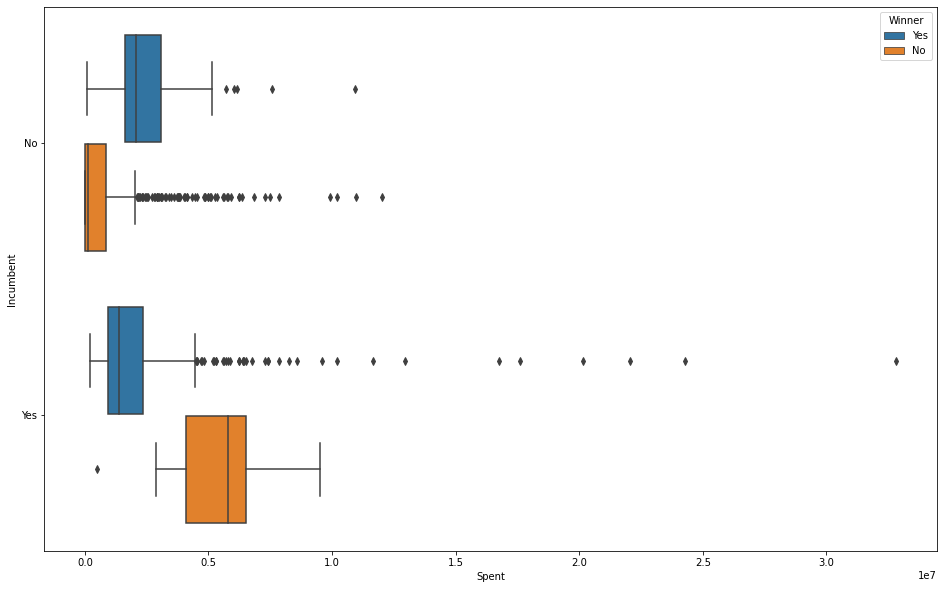

In [68]:
fig, ax = plt.subplots(figsize = (16,10))
sns.boxplot(y = all_dist['Incumbent'], x = all_dist['Spent'], hue = all_dist['Winner'], ax = ax, orient = 'h');

How often does the candidate who raised more money win a race?

How often does the candidate who spent more money win a race?

Does the difference between either money raised or money spent seem to influence the likelihood of a candidate winning a race?

How often does the incumbent candidate win a race?

Can you detect any relationship between amount of money raised and the incumbent status of a candidate?

In [72]:
all_dist.corr()

37262827.0